In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Intron chain, TSS, TES triplet analysis

In [13]:
# get list of detected filtered isoforms
sg = swan.read('../swan/swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

Read in graph from ../swan/swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687


In [14]:
temp = t_df.loc[t_df.ttrip.duplicated(keep=False)].copy(deep=True)
temp = temp.sort_values(by='ttrip')
n = len(temp.ttrip.unique().tolist())
print('Found {} transcripts w/ duplicated triplets'.format(n))
print(temp.head())

Found 1091 transcripts w/ duplicated triplets
             tname                 gid   gname  \
37126   ABCB11-201   ENSG00000073734.9  ABCB11   
239683  ABCB11-207   ENSG00000073734.9  ABCB11   
237242   ABCC2-204  ENSG00000023839.11   ABCC2   
55762    ABCC2-202  ENSG00000023839.11   ABCC2   
59103    ABCC4-201  ENSG00000125257.14   ABCC4   

                                                     path                tid  \
37126   [135523, 135524, 135525, 135526, 135527, 13552...  ENST00000263817.7   
239683  [135576, 135524, 135525, 135526, 135527, 13552...  ENST00000650372.1   
237242  [483394, 483395, 483396, 483397, 483398, 48339...  ENST00000647814.1   
55762   [483469, 483395, 483396, 483397, 483398, 48339...  ENST00000370449.9   
59103   [615868, 615808, 615809, 615810, 615811, 61581...  ENST00000376887.9   

                                                 loc_path  annotation novelty  \
37126   [545237, 545236, 545235, 545234, 545233, 54523...        True   Known   
239683  [5

In [15]:
def check_gene(df, counts, gname):
    print(t_df.loc[t_df.gname == gname, 'tss_gene_num'].max())
    print(t_df.loc[t_df.gname == gname, 'tes_gene_num'].max())
    print(t_df.loc[t_df.gname == gname, 'intron_chain_gene_num'].max())
    print()
    print(len(t_df.loc[t_df.gname == gname, 'tss_cluster'].unique().tolist()))
    print(len(t_df.loc[t_df.gname == gname, 'tes_cluster'].unique().tolist()))
    print(len(t_df.loc[t_df.gname == gname, 'intron_chain'].unique().tolist()))
    print()
    print(counts.loc[(counts.gname == gname)&(counts.source=='all')])

In [16]:
# check_gene(t_df, counts, 'COL1A1')
check_gene(t_df, counts, 'ELN')

7
13
158

7
13
158

         tss  intron_chain  tes  tss_ic_tes  splicing_ratio source  \
21978.0    7           158   13         158            15.8    all   

                        gid gname         biotype biotype_category     tf  
21978.0  ENSG00000049540.16   ELN  protein_coding   protein_coding  False  


In [45]:
# add triplets for samples
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
temp = compute_triplets(t_df,
                        df,
                        min_tpm=1,
                        groupby='sample')
counts = pd.concat([counts, temp])

# add tpm on the sample level to the table
df = pd.read_csv('../talon/human_talon_abundance.tsv', sep='\t')
gene_df,_ = get_tpm_table(df,
                         how='gene',
                         min_tpm=1, 
                         gene_subset='polya',
                         groupby='sample')
gene_df = gene_df.melt(ignore_index=False)
gene_df.rename({'value':'tpm'}, axis=1, inplace=True)
gene_df.reset_index(inplace=True)
gene_df.rename({'index': 'gid'}, axis=1, inplace=True)
counts = counts.merge(gene_df, how='left', left_on=['source', 'gid'], right_on=['biosample', 'gid'])

In [11]:
# save all observed triplets
temp = counts.loc[counts.source == 'obs']
temp.to_csv('obs_triplets.tsv', sep='\t', index=False)

In [12]:
# save triplets
counts.to_csv('triplets.tsv', sep='\t', index=False)

## Plotting

In [2]:
c_dict, order = get_biosample_colors()
c_dict['GENCODE'] = 'k'
c_dict['obs'] = 'k'
counts = pd.read_csv('triplets.tsv', sep='\t')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


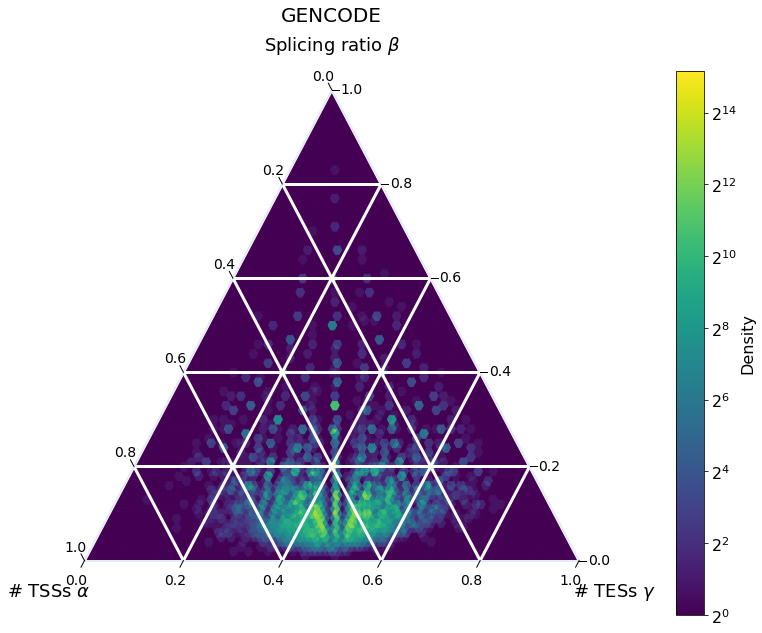

In [3]:
# gencode
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'},
            density=True,
            density_scale=100,
            # density_vmax=2^10,
            log_density=True,
            scatter=False,
            title='GENCODE',
            opref='figures/human')

In [4]:
# import ternary
# ?ternary.heatmap

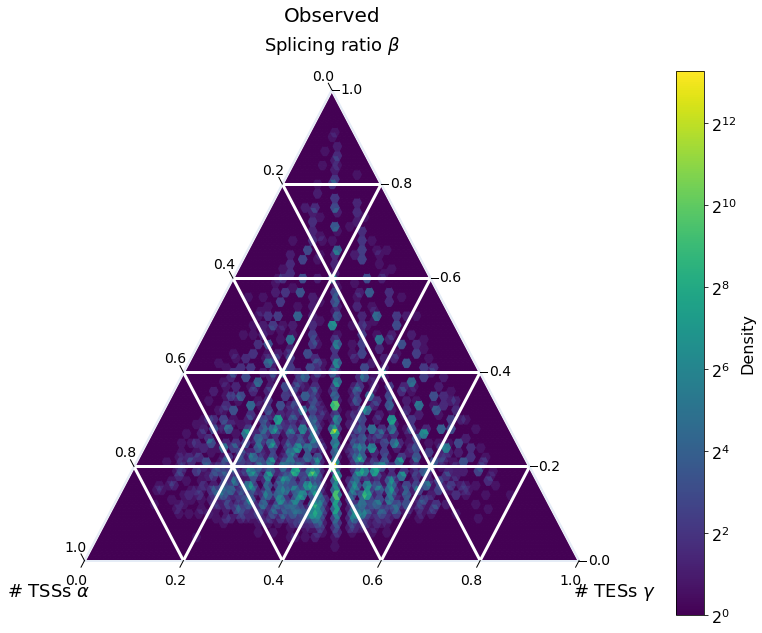

In [4]:
# observed
temp = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'},
            density=True,
            density_scale=100,
            log_density=True,
            scatter=False,
            title='Observed',
            opref='figures/human')

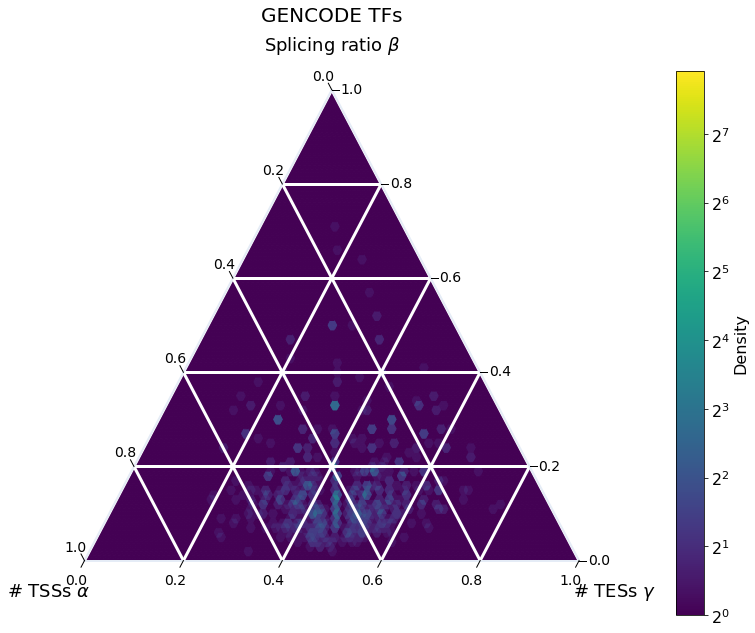

In [19]:
# all tfs in gencode
temp = plot_dorito(counts,
                top='splicing_ratio',
                # hue='intron_chain',
                scatter=False,
                subset={'source': 'GENCODE', 'tf': True},
                jitter=True,
                density=True,
                density_scale=100,
                log_density=True,
                title='GENCODE TFs',
                opref='figures/human')

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
c_dict, order = get_biosample_colors()
c_dict['GENCODE'] = 'k'
c_dict['obs'] = 'k'
counts = pd.read_csv('triplets.tsv', sep='\t')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


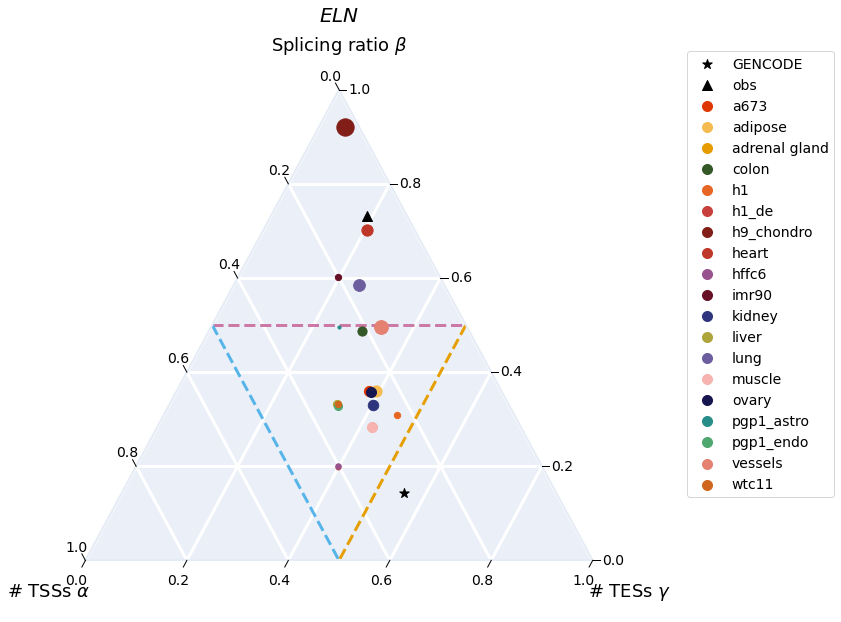

In [3]:
# ELN
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            size='tpm', 
            sectors=True,
            log_size=True,
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

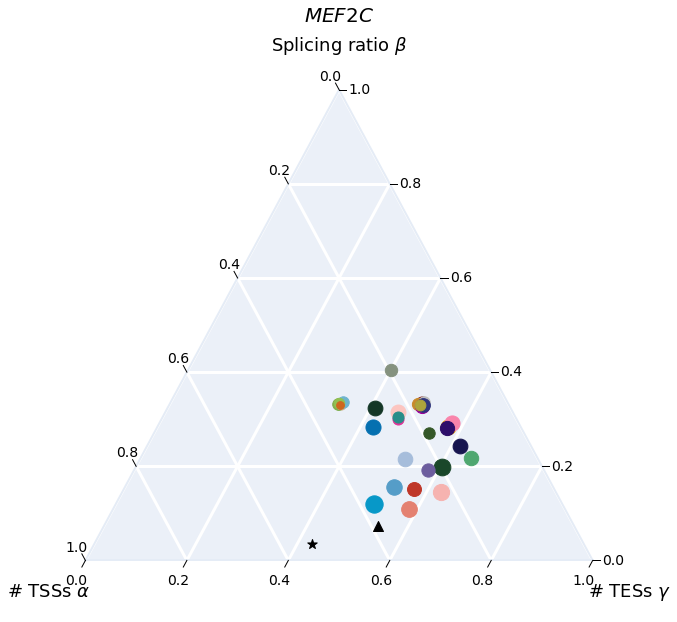

In [4]:
# MEF2C
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            size='tpm', 
            log_size=True,
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

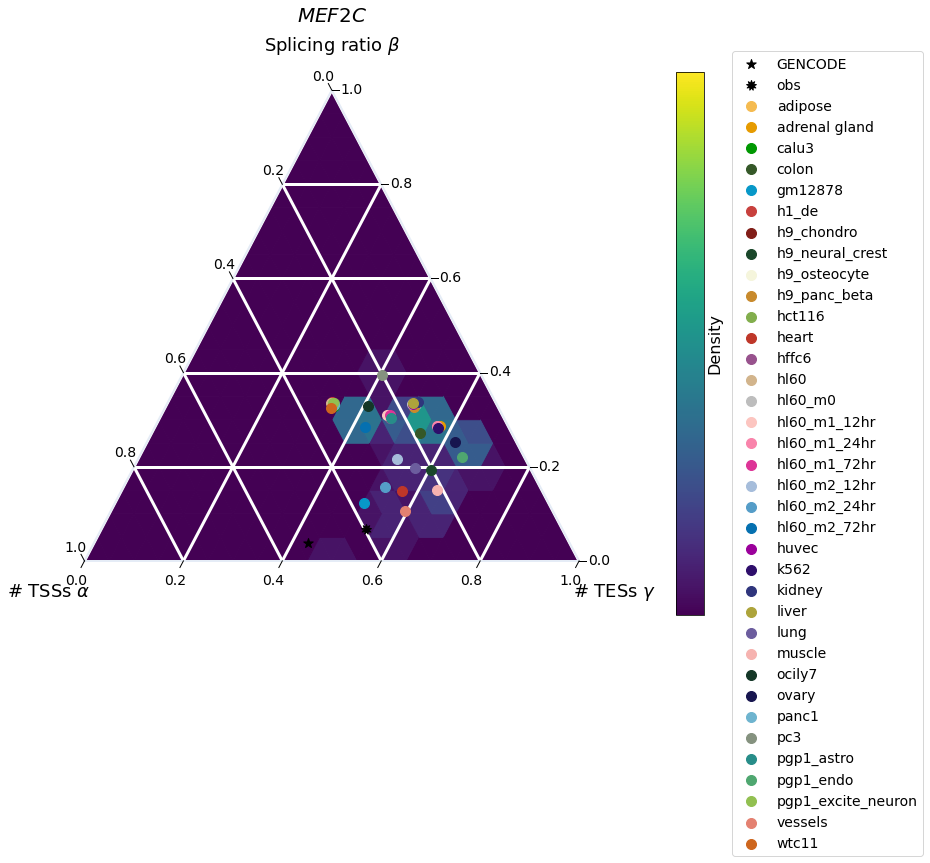

In [25]:
# MEF2C
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))}, 
            opref='figures/human')

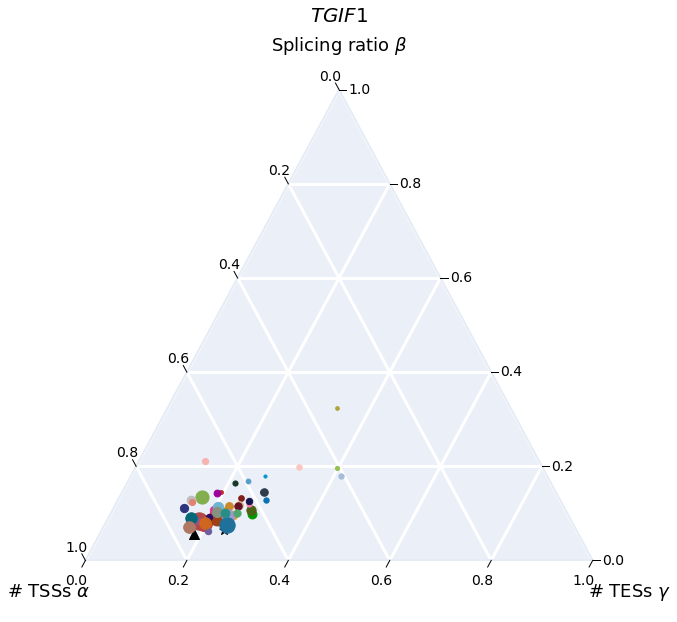

In [14]:
# TGIF1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TGIF1',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

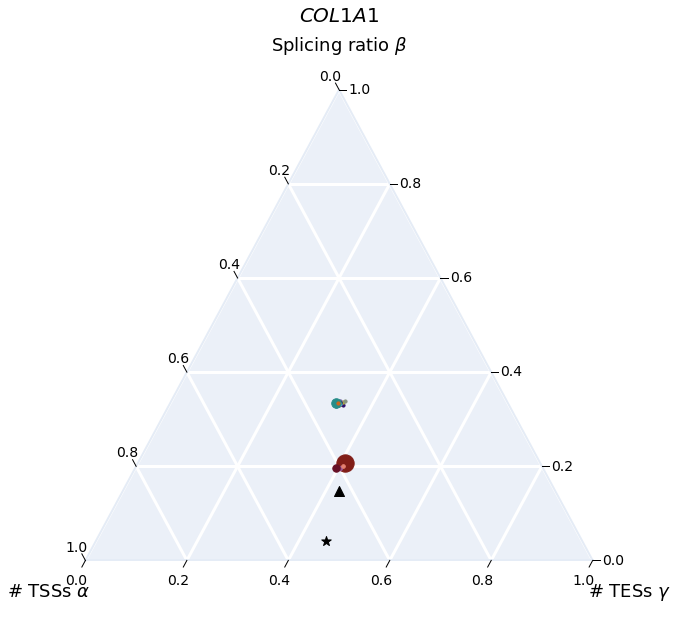

In [12]:
# COL1A1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

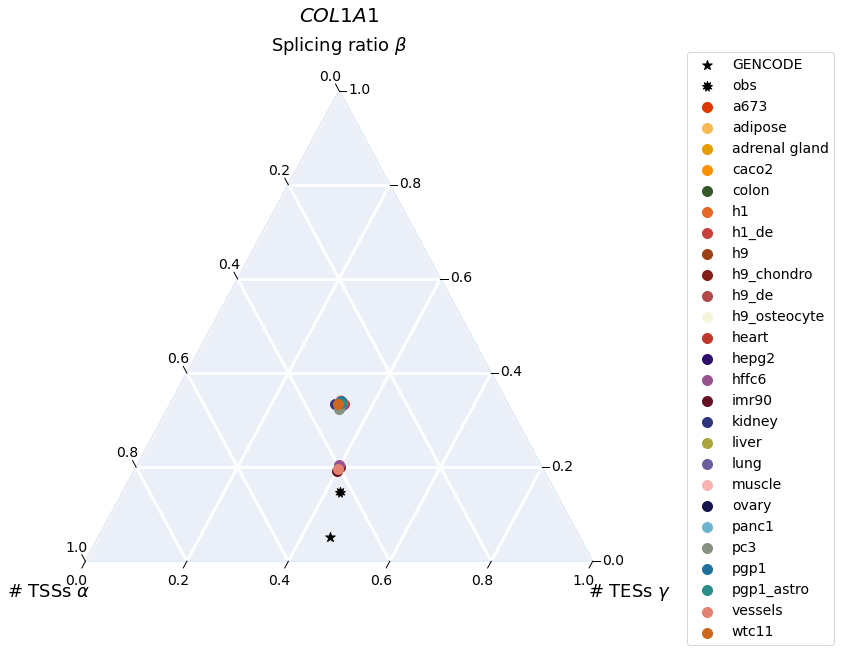

In [5]:
# COL1A1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

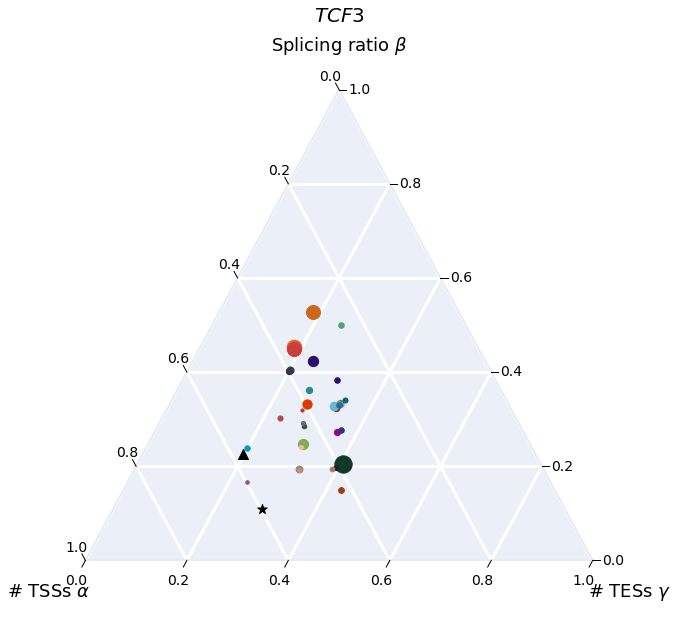

In [17]:
# TCF3
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

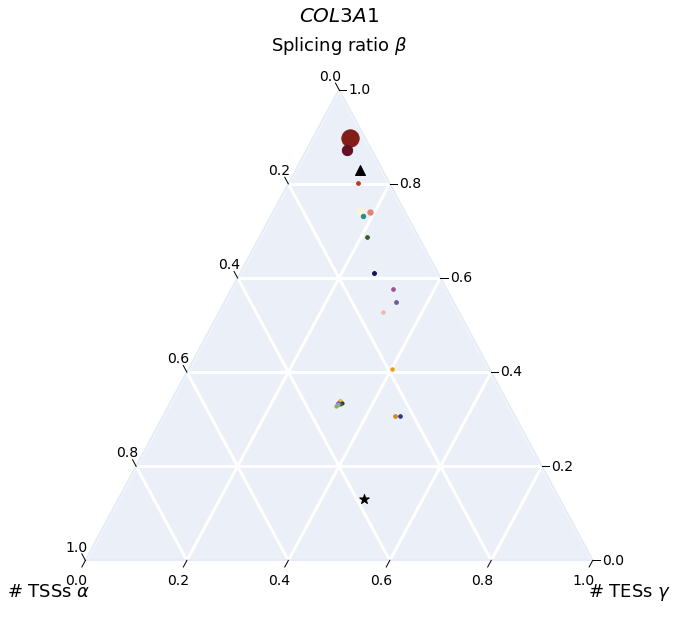

In [20]:
# COL3A1
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL3A1',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

In [1]:
# DES
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='DES',
            size='tpm', 
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': '^'},
            jitter=True,
            legend=False,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},
            opref='figures/human')

NameError: name 'plot_dorito' is not defined

In [23]:
counts.loc[(counts.gname == 'TCF3')&(counts.source=='obs')]

tss  intron_chain  tes  tss_ic_tes  splicing_ratio source  \
118682    9            21    3          21             3.5    obs   

                       gid gname         biotype biotype_category    tf  \
118682  ENSG00000071564.14  TCF3  protein_coding   protein_coding  True   

       biosample  tpm  
118682       NaN  NaN

tss  intron_chain  tes  tss_ic_tes  splicing_ratio         source  \
164969    2             4    2           4             2.0  adrenal gland   
346512    3             6    2           6             2.4          heart   
575046    3             4    2           4             1.6         muscle   

                       gid gname         biotype biotype_category    tf  \
164969  ENSG00000071564.14  TCF3  protein_coding   protein_coding  True   
346512  ENSG00000071564.14  TCF3  protein_coding   protein_coding  True   
575046  ENSG00000071564.14  TCF3  protein_coding   protein_coding  True   

            biosample        tpm  total  tss_ratio  tes_ratio  top_ratio  \
164969  adrenal gland  14.802999    6.0   0.333333   0.333333   0.333333   
346512          heart  12.782108    7.4   0.405405   0.270270   0.324324   
575046         muscle  21.980713    6.6   0.454545   0.303030   0.242424   

        a_jitter  b_jitter  c_jitter  
164969  0.334430  0.336976  0.334287  
346512  0.402717  0.324329  0.268365  
575046  0.456757  0.236218  0.311267

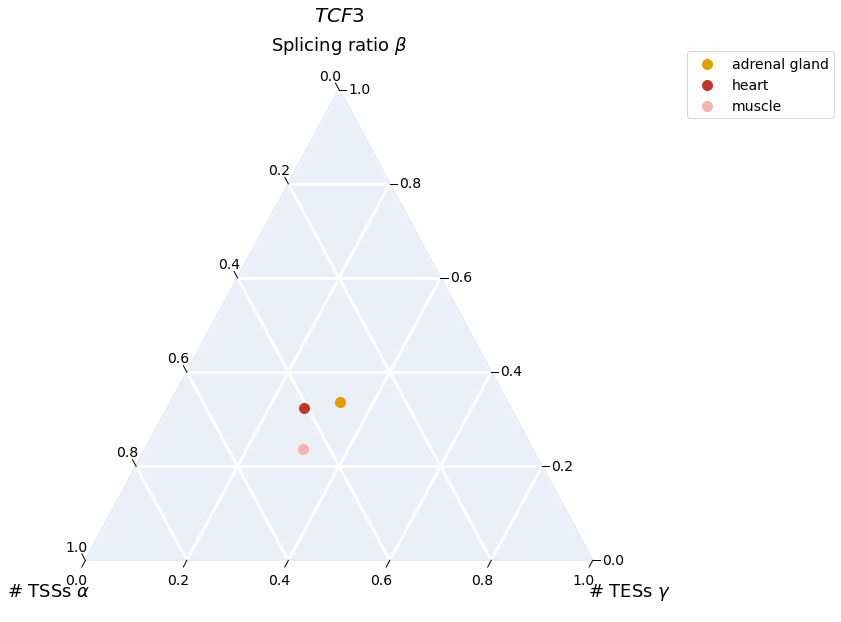

In [25]:
subset = ['heart', 'adrenal gland', 'muscle']
# TCF3
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':subset})
temp.head()

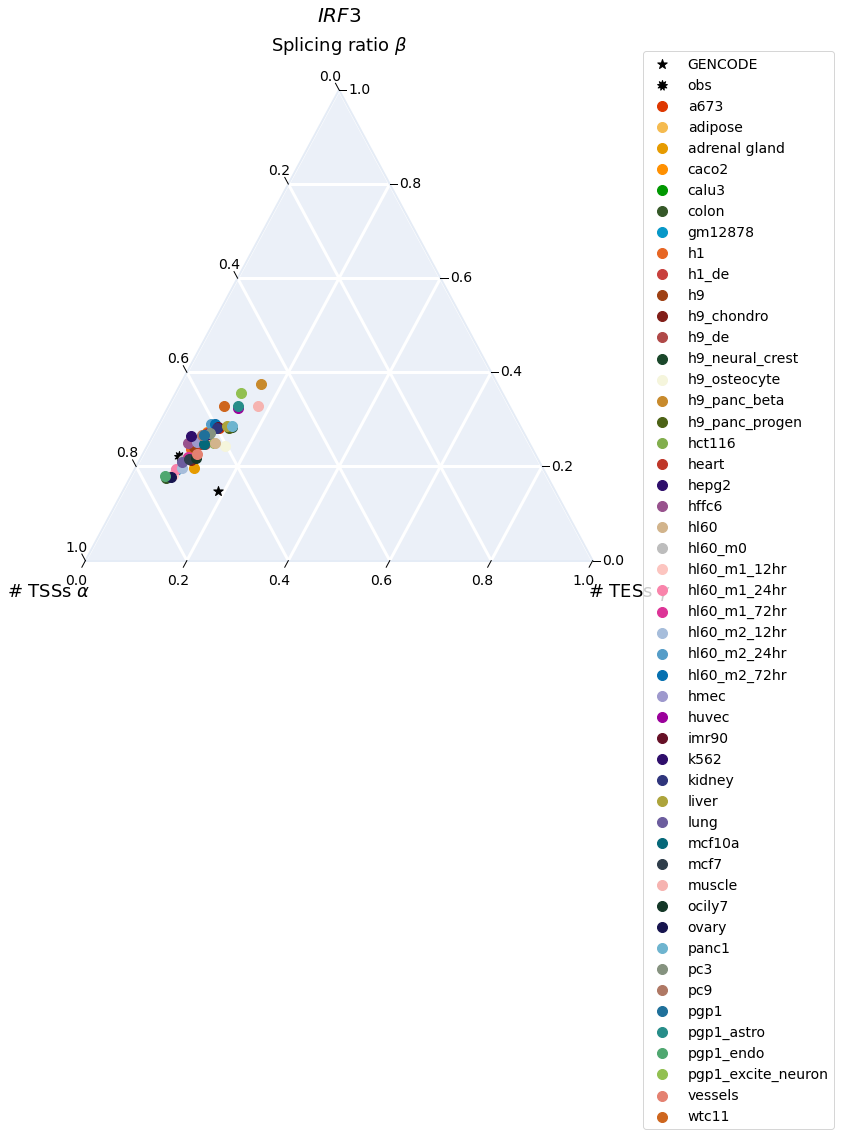

In [26]:
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='IRF3',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))})

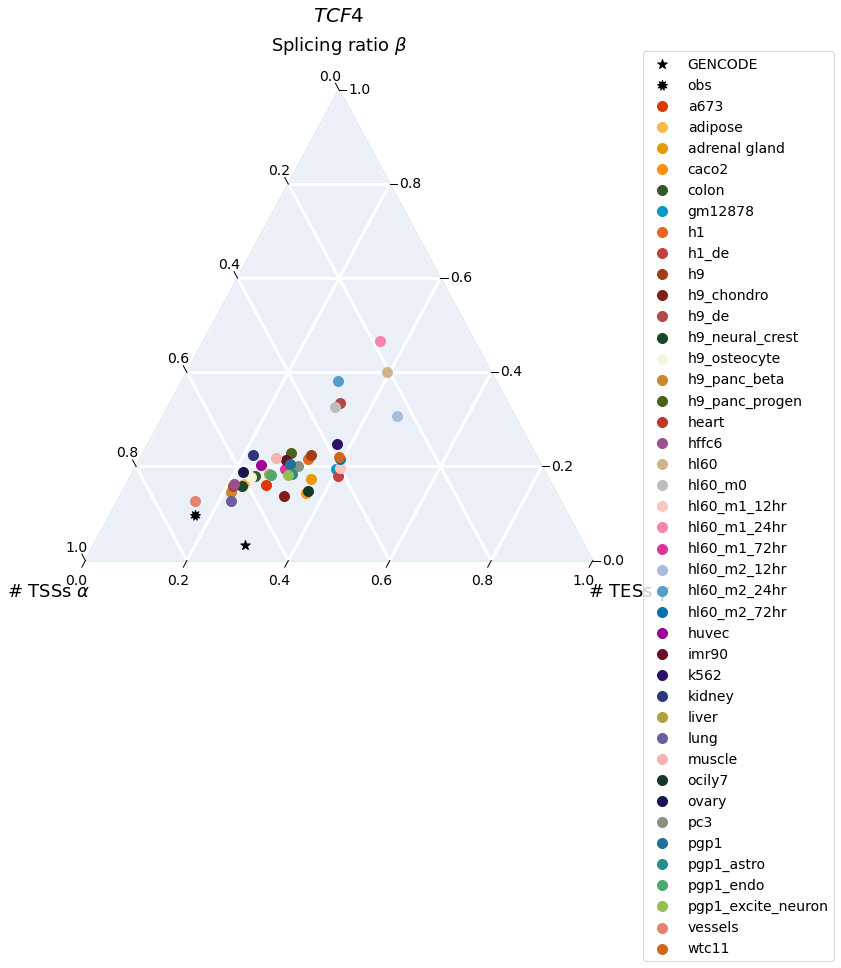

In [27]:
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF4',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))})

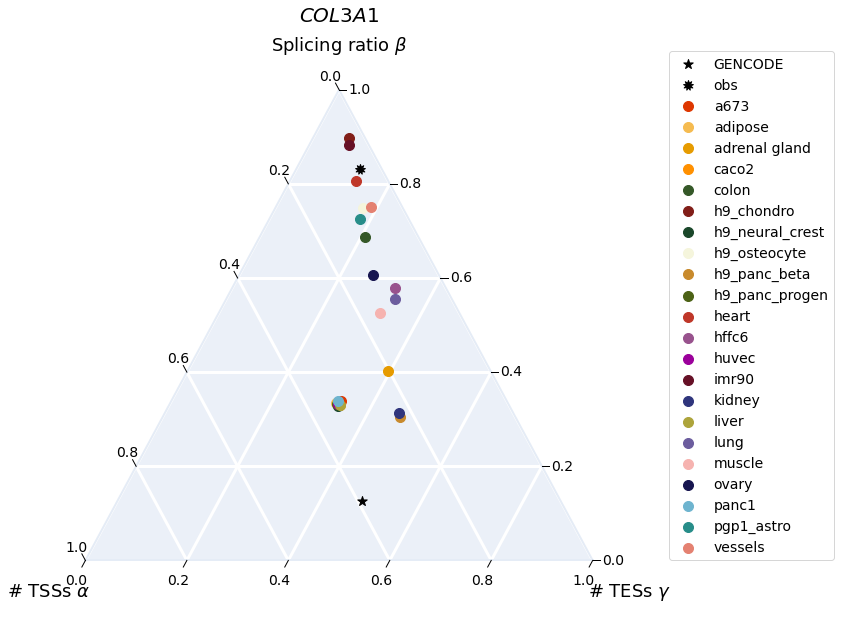

In [7]:
# COL3A1
c_dict = c_dict
c_dict['GENCODE'] = 'k'
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL3A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},)

In [8]:
counts.loc[(counts.gname == 'COL3A1')&(counts.source=='obs')]
counts.loc[counts.gname == 'COL3A1']

tss  intron_chain  tes  tss_ic_tes  splicing_ratio           source  \
12388     4             6    5           6        1.333333          GENCODE   
71168     4            43    5          43        9.555556              all   
129110    1            39    3          39       19.500000              obs   
150384    1             1    1           1        1.000000             a673   
160773    1             1    1           1        1.000000          adipose   
172783    1             3    2           3        2.000000    adrenal gland   
185838    1             1    1           1        1.000000            caco2   
211062    1            10    2          10        6.666667            colon   
277215    1            38    2          38       25.333333       h9_chondro   
299333    1             1    1           1        1.000000  h9_neural_crest   
309763    1            13    2          13        8.666667     h9_osteocyte   
319886    1             2    2           2        1.333333     h9_panc_beta   
330647    1             1    1           1        1.000000   h9_panc_progen   
355099    1            18    2          18       12.000000            heart   
382330    1            11    3          11        5.500000            hffc6   
484095    1             1    1           1        1.000000            huvec   
495365    1            32    2          32       21.333333            imr90   
520219    1             2    2           2        1.333333           kidney   
532343    1             1    1           1        1.000000            liver   
545416    1            10    3          10        5.000000             lung   
581857    1             5    2           5        3.333333           muscle   
605133    1             7    2           7        4.666667            ovary   
617429    1             1    1           1        1.000000            panc1   
665072    1            12    2          12        8.000000       pgp1_astro   
700999    1            24    3          24       12.000000          vessels   

                       gid   gname         biotype biotype_category     tf  \
12388   ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
71168   ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
129110  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
150384  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
160773  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
172783  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
185838  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
211062  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
277215  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
299333  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
309763  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
319886  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
330647  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
355099  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
382330  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
484095  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
495365  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
520219  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
532343  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
545416  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
581857  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
605133  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
617429  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
665072  ENSG00000168542.14  COL3A1  protein_coding   protein_coding  False   
700

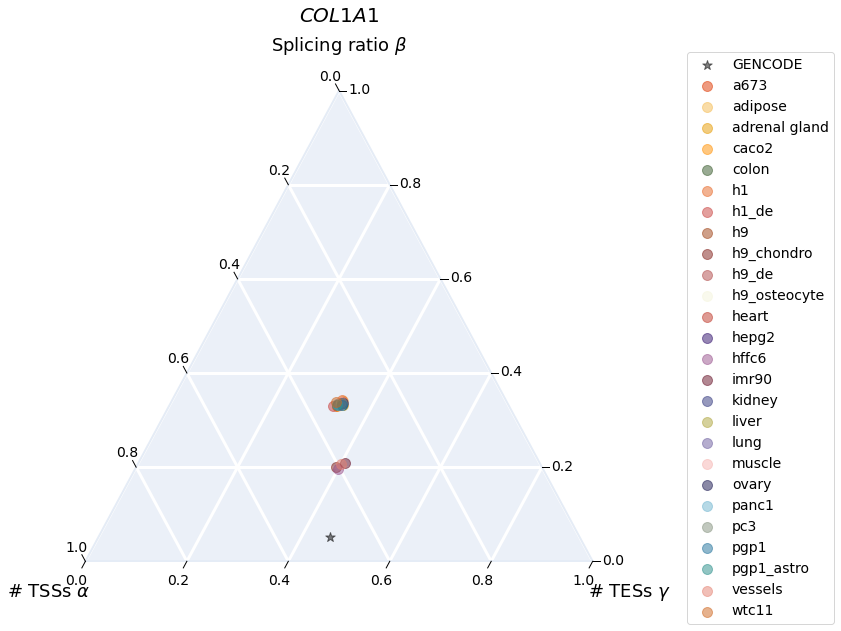

In [9]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

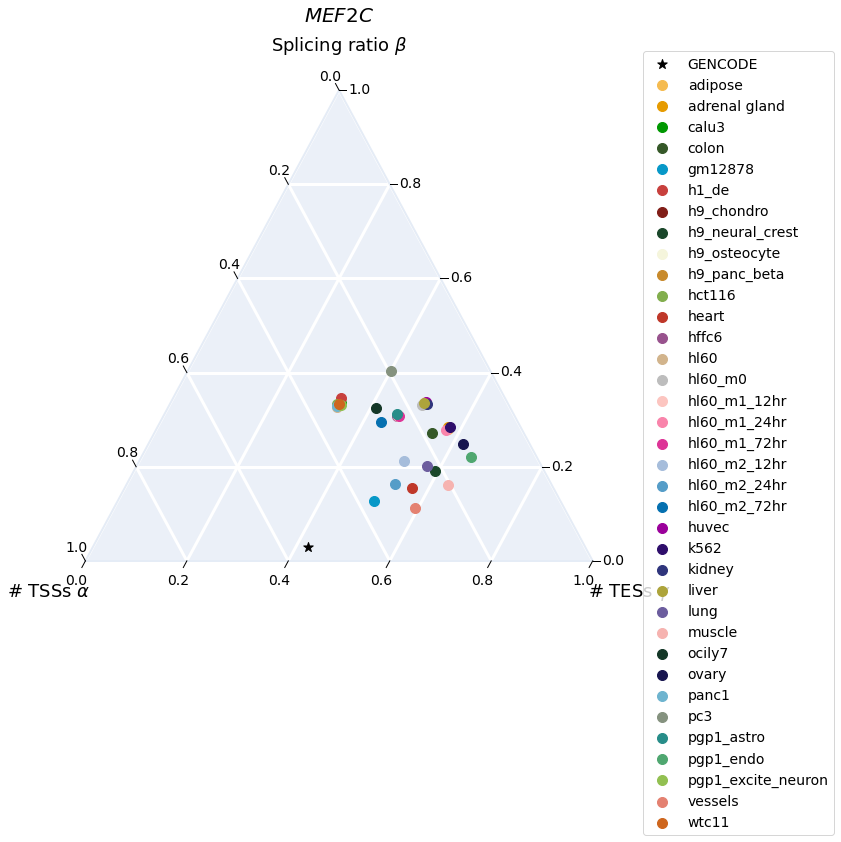

In [10]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

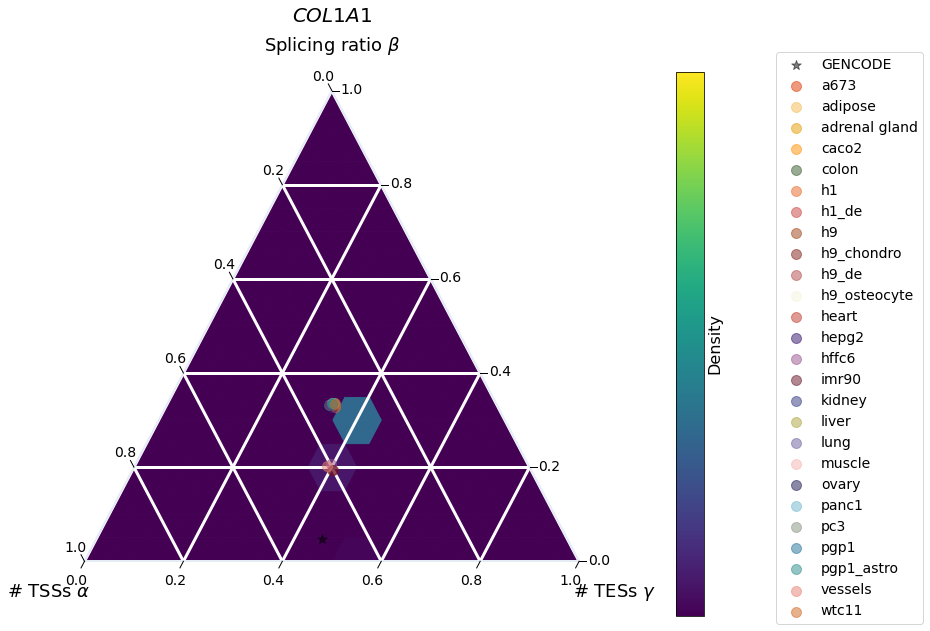

In [11]:
# COL1A1
c_dict = c_dict
c_dict['GENCODE'] = 'k'
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            density=True,
            density_scale=20,
            jitter=True,
            alpha=0.5,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

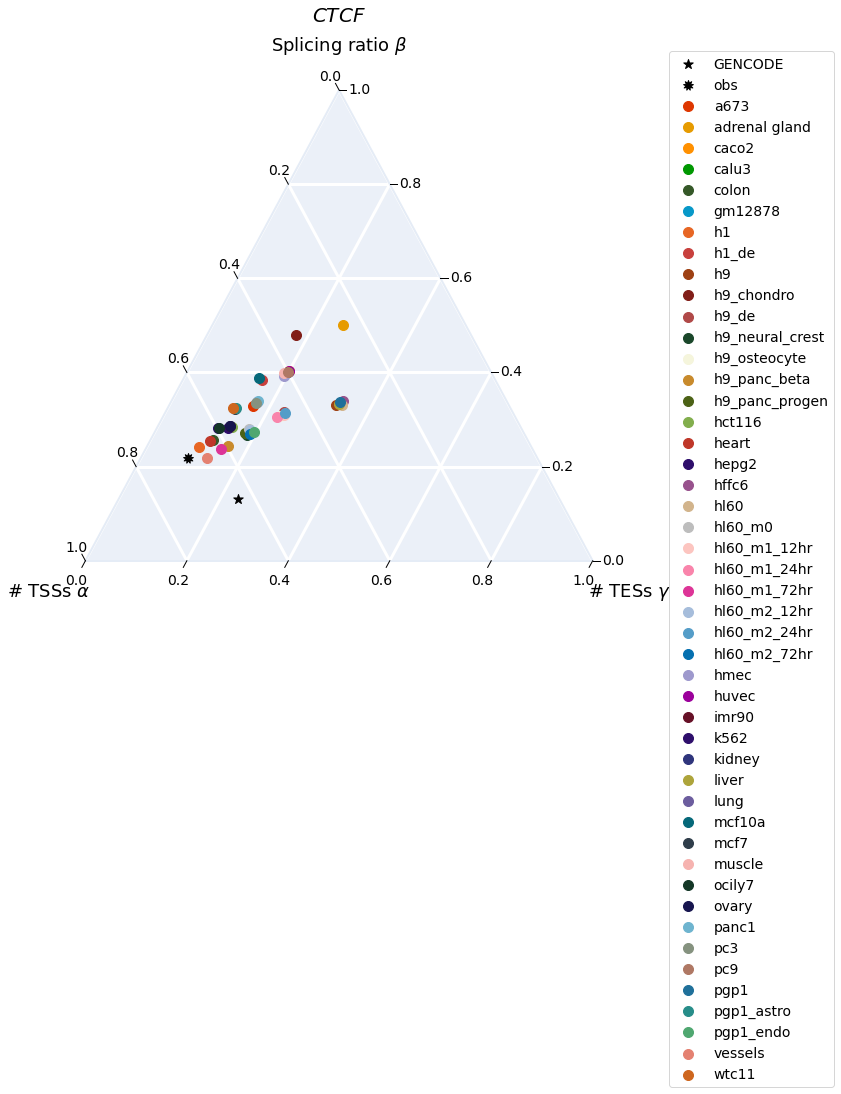

In [12]:
# CTCF
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='CTCF',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*', 'obs': (9,1,0)},
            jitter=True,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all']))},)

In [32]:
# counts.loc[counts.gname == 'CTCF', ['tss', 'tes', 'splicing_ratio', 'source']]

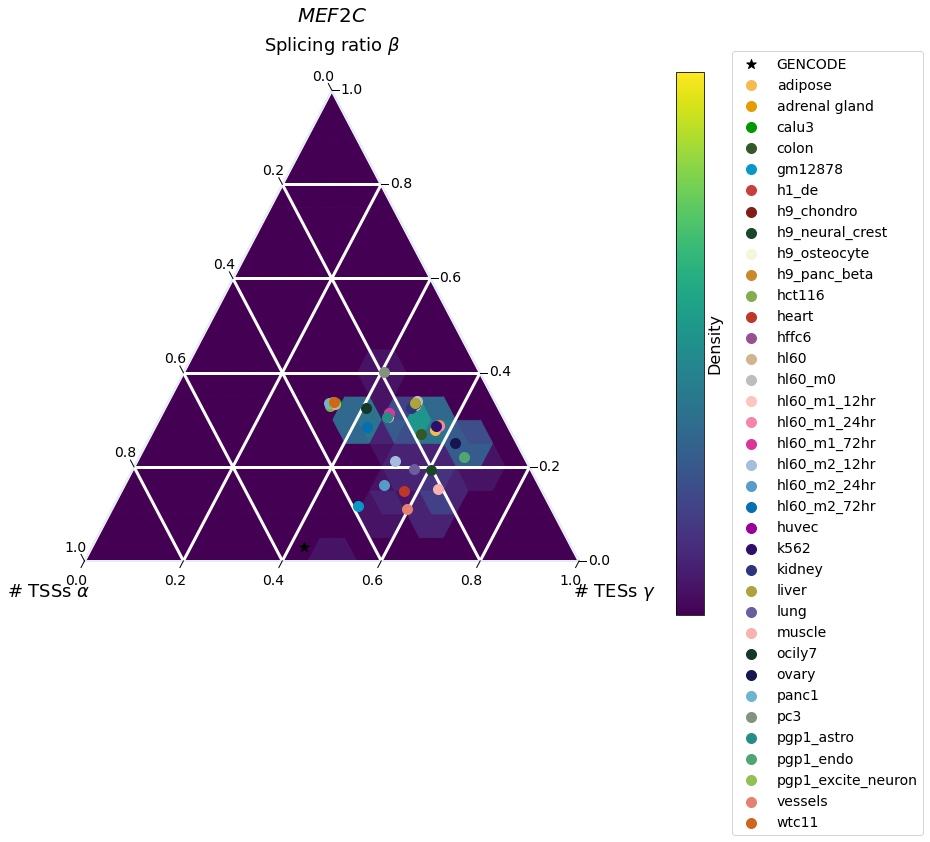

In [14]:
# MEF2C
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='MEF2C',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

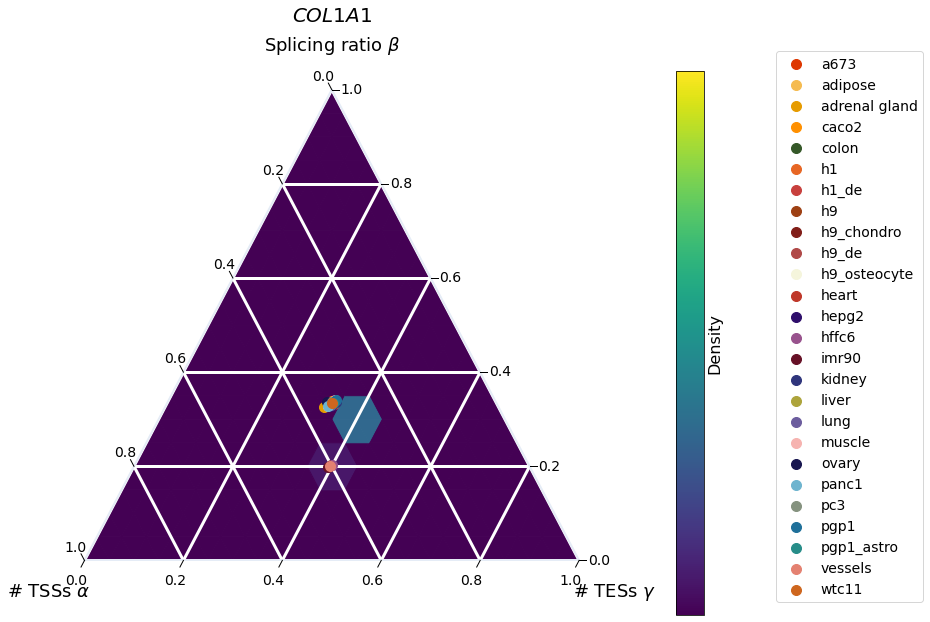

In [15]:
# COL1A1
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='COL1A1',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            density=True,
            density_scale=20,
            subset={'source':list(set(counts.source.unique().tolist())-set(['GENCODE', 'all', 'obs']))})

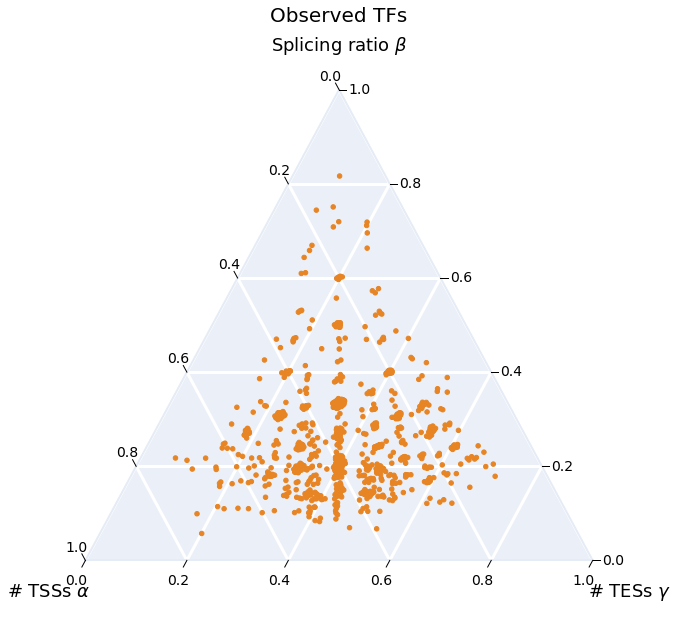

In [16]:
# all tfs in observed example
temp = plot_dorito(counts,
            top='splicing_ratio',
            # hue='intron_chain',
            # density=True, 
            # density_scale=20,
            jitter=True,
            subset={'source': 'obs', 'tf': True},
            title='Observed TFs')

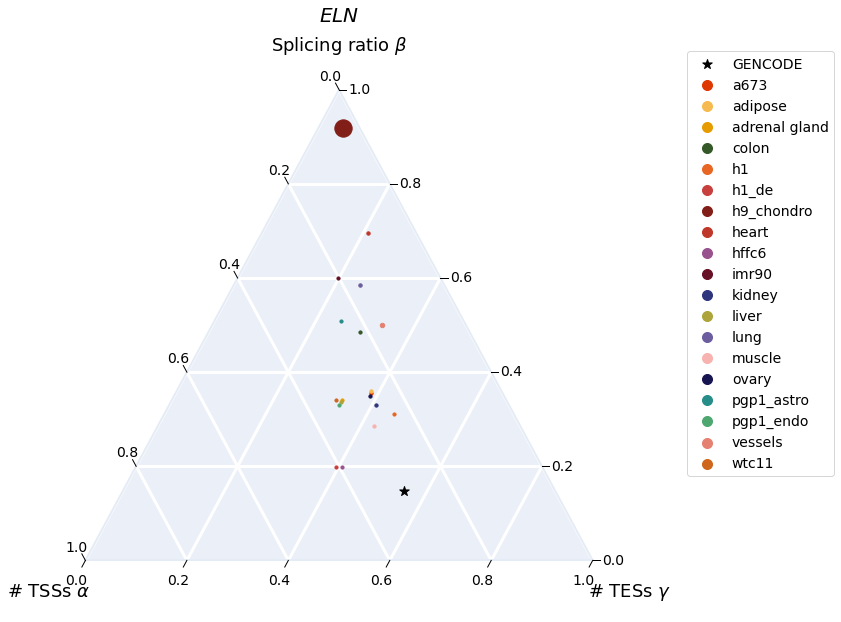

In [18]:
# ELN
temp = plot_dorito(counts,
            top='splicing_ratio', 
            gene='ELN',
            hue='source',
            cmap=c_dict,
            mmap={'GENCODE': '*'},
            jitter=True,
            size='tpm',
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

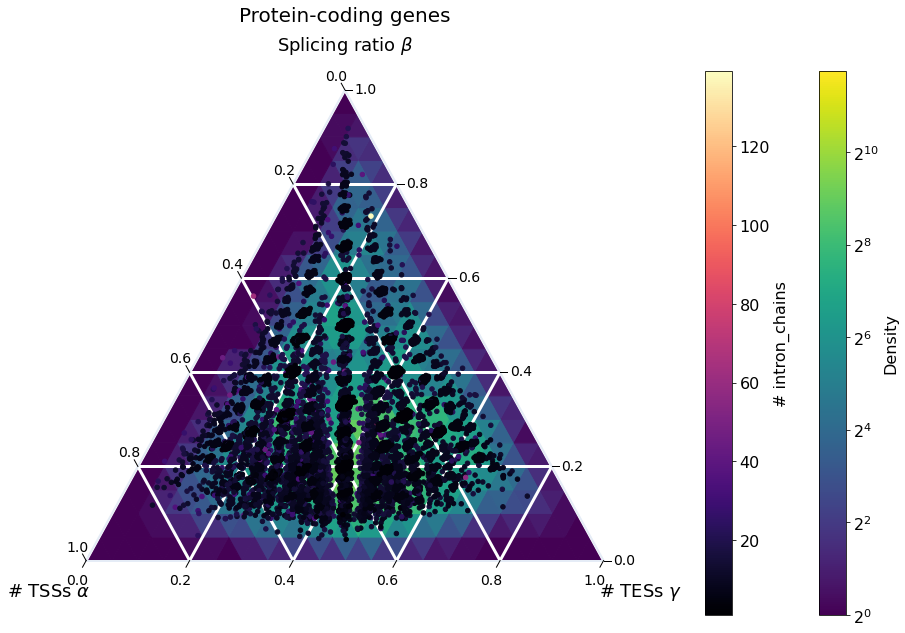

In [19]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            density=True,
            density_scale=20,
            log_density=True,
            jitter=True,
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

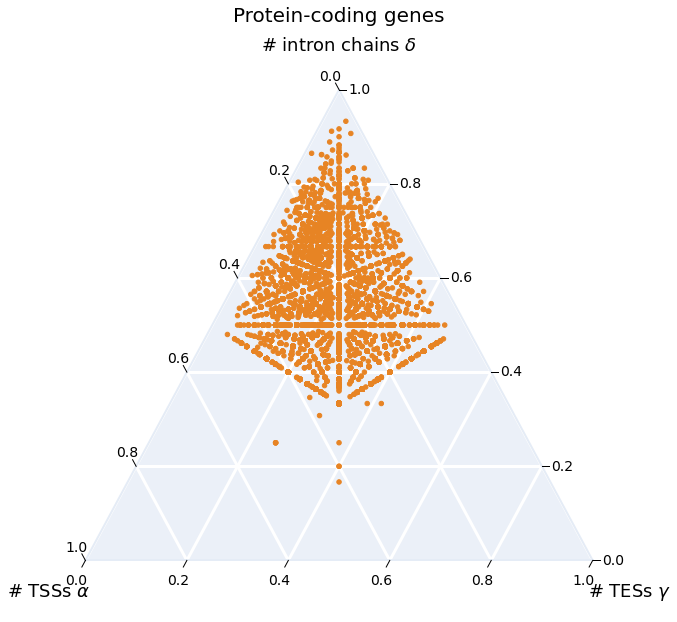

In [21]:
# all protein-coding genes in gencode example
_ = plot_dorito(counts,
            top='intron_chain',
            subset={'biotype': 'protein_coding', 'source': 'obs'},
            title='Protein-coding genes')

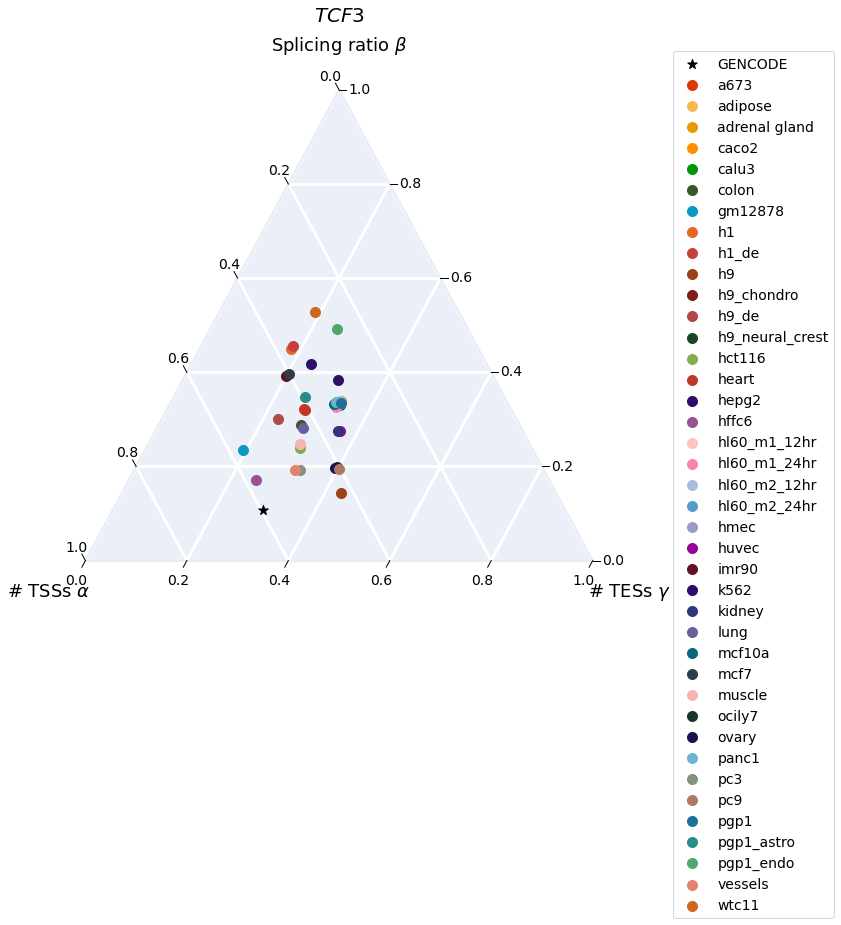

In [22]:
# gene example
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            jitter=True,
            mmap={'GENCODE': '*'},
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

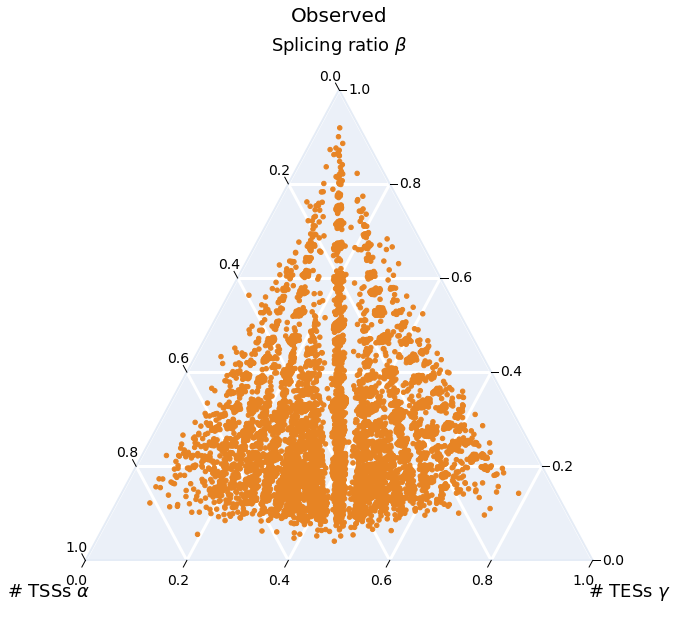

In [38]:
# obs example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'obs'},
            jitter=True,
            title='Observed')

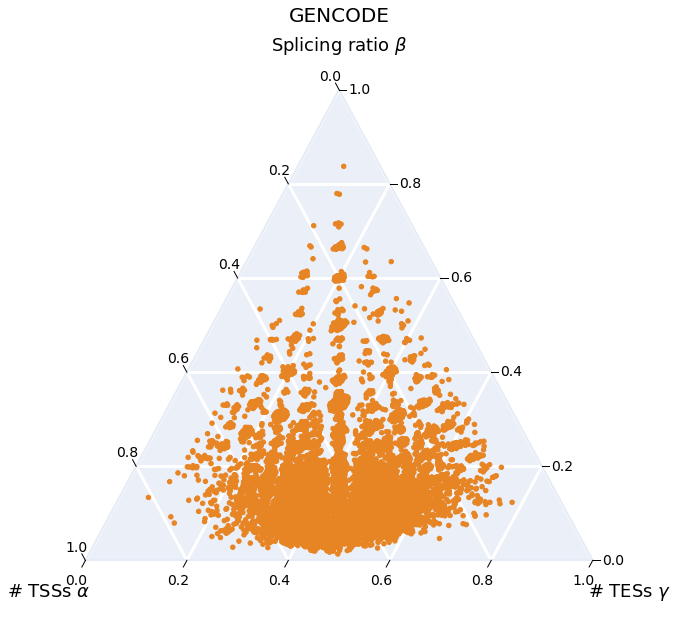

In [37]:
# gencode example
_ = plot_dorito(counts,
            top='splicing_ratio',
            subset={'source': 'GENCODE'},
            jitter=True, 
            title='GENCODE')

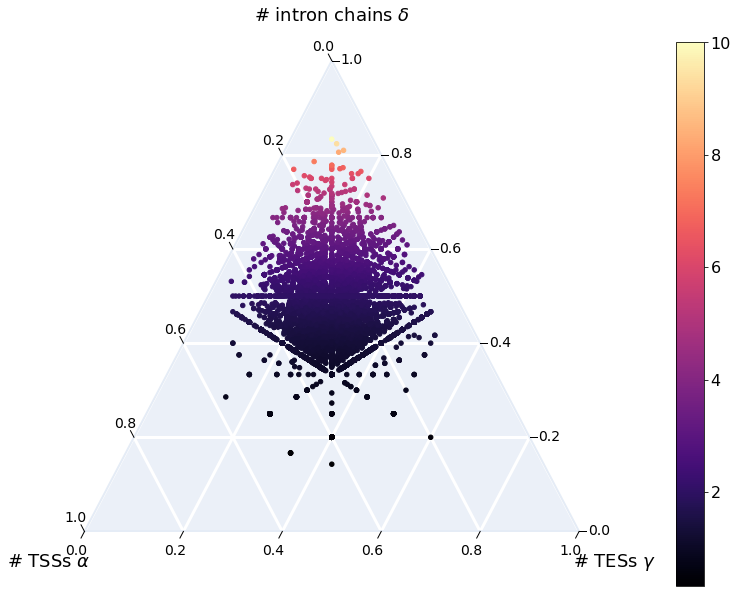

In [25]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='intron_chain',
            hue='splicing_ratio',
            subset={'source': 'GENCODE'})

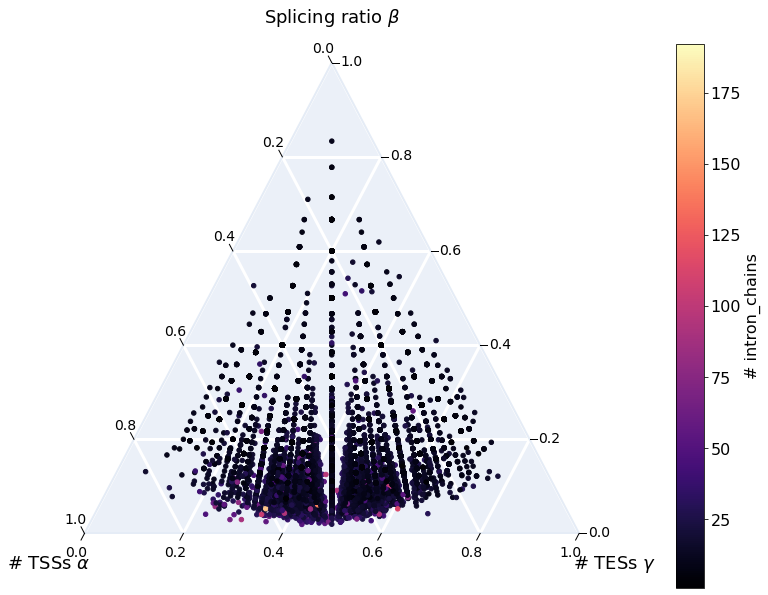

In [26]:
# gencode example - color by splicing ratio
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source': 'GENCODE'})

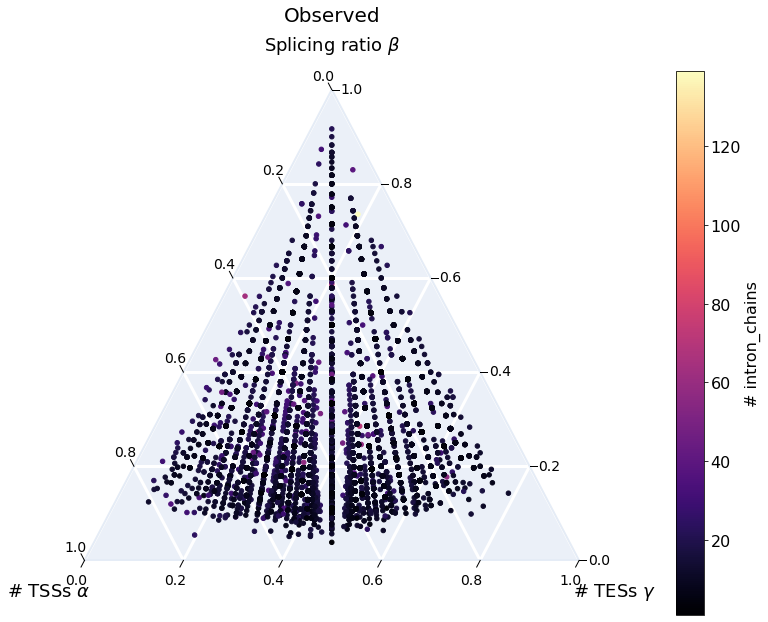

In [27]:
# observed example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'obs'},
            title='Observed')

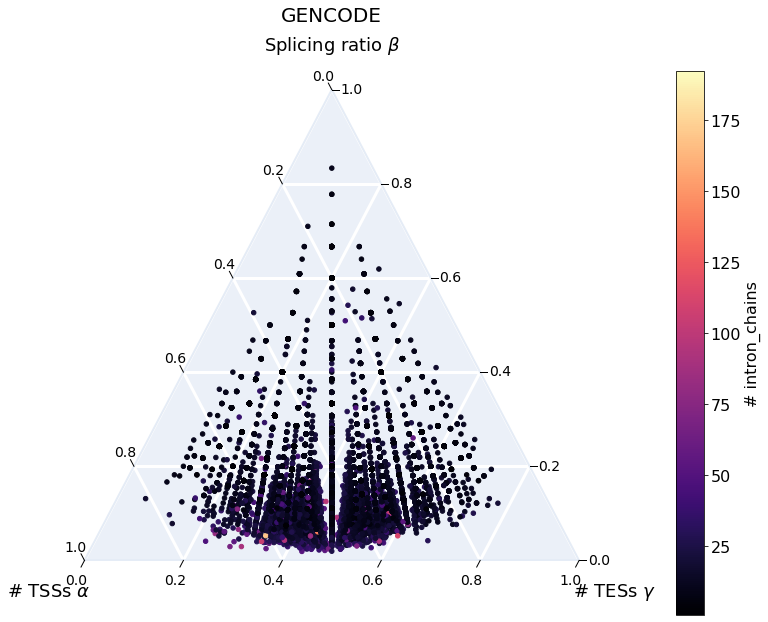

In [28]:
# gencode example - color by n ic
_ = plot_dorito(counts,
            top='splicing_ratio',
            hue='intron_chain',
            subset={'source':'GENCODE'},
            title='GENCODE')

## Counting genes in different GISX regions

In [36]:
def count_gisx_region_genes(df, source, tss, tes, spl):
    df = df.loc[df.source == source].copy(deep=True)
    df['total'] = df.tss+df.tes+df.splicing_ratio
    df['tss_ratio'] = df.tss / df.total
    df['tes_ratio'] = df.tes / df.total
    df['spl_ratio'] = df.splicing_ratio / df.total
    
    t = len(df.index)
    print('{} genes are in {}'.format(t, source))
    
    # tss-high
    n = len(df.loc[df.tss_ratio > tss].index)
    print('{} ({:.2f}%) genes are TSS-high in {}'.format(n, (n/t)*100, source))
    
    # tes-high
    n = len(df.loc[df.tes_ratio > tes].index)
    print('{} ({:.2f}%) genes are TES-high in {}'.format(n, (n/t)*100, source))
    
    # splicing-high
    n = len(df.loc[df.spl_ratio > spl].index)
    print('{} ({:.2f}%) genes are splicing-high in {}'.format(n, (n/t)*100, source))
    
    # simple genes
    n = len(df.loc[(df.tss_ratio <= tss)&(df.tes_ratio <= tes)&(df.spl_ratio <= spl)].index)
    print('{} ({:.2f}%) genes are simple in {}'.format(n, (n/t)*100, source))
    

# GENCODE
count_gisx_region_genes(counts, 'GENCODE', .5, .5, .5)

# observed
count_gisx_region_genes(counts, 'obs', .5, .5, .5)

58780 genes are in GENCODE
3096 (5.27%) genes are TSS-high in GENCODE
3599 (6.12%) genes are TES-high in GENCODE
195 (0.33%) genes are splicing-high in GENCODE
51890 (88.28%) genes are simple in GENCODE
25198 genes are in obs
1761 (6.99%) genes are TSS-high in obs
1617 (6.42%) genes are TES-high in obs
890 (3.53%) genes are splicing-high in obs
20930 (83.06%) genes are simple in obs


## How many GENCODE genes are (1,1,1)?

In [21]:
counts = pd.read_csv('triplets.tsv', sep='\t')
c = counts.loc[counts.source == 'GENCODE'].copy(deep=True)
# c = c.loc[c.biotype == 'protein_coding']
t = len(c.index)
n = len(c.loc[(c.tss==1)&(c.tes==1)&(c.intron_chain==1)].index)
print('{} / {} ({:.2f}%) polyA genes in GENCODE have triplet (1,1,1)'.format(n,t,(n/t)*100))

36296 / 58780 (61.75%) polyA genes in GENCODE have triplet (1,1,1)


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


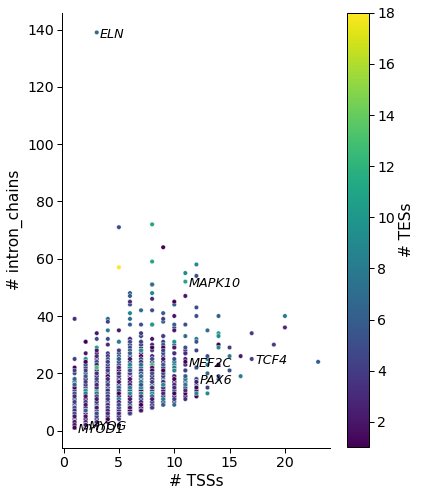

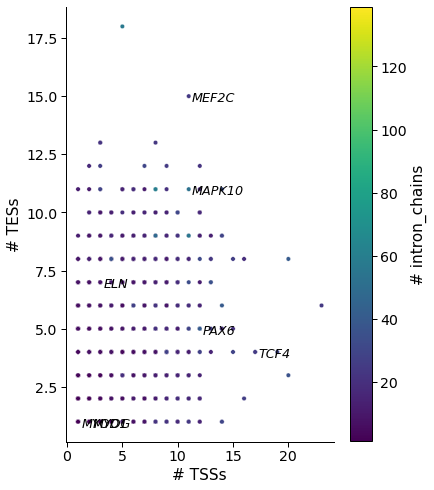

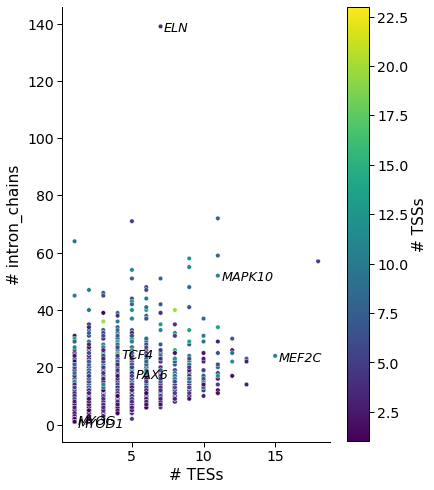

In [29]:
genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C', 'MYOD1', 'MYOG']
plot_n_ic_tss_tes(counts.loc[counts.source=='obs'], 
                  label_genes=genes,
                  kind='obs',
                  opref='figures/human')

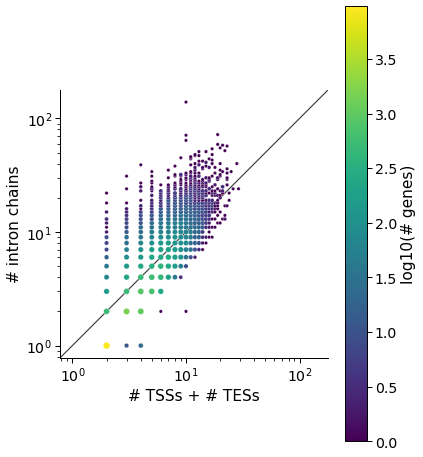

In [30]:
plot_genes_n_ic_ends(counts.loc[counts.source=='obs'], 
                     kind='obs', 
                     opref='figures/human')

In [31]:
# get list of detected filtered isoforms
sg = swan.read('../swan/swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
t_df, regions, counts = get_ic_tss_tes(sg,
                                         df,
                                         min_tpm=1, 
                                         gene_subset='polya',
                                         annot_slack=200,
                                         novel_slack=100)

# add 90% set triplets
df = pd.read_csv('../swan/isos_sample_gene_90.tsv', sep='\t')
temp = compute_triplets(t_df,
                        df, 
                        groupby='sample')
counts = pd.concat([counts, temp])

# add tpm on the sample level to the table
df = pd.read_csv('../talon/human_talon_abundance.tsv', sep='\t')
gene_df,_ = get_tpm_table(df,
                         how='gene',
                         min_tpm=1, 
                         gene_subset='polya',
                         groupby='sample')
gene_df = gene_df.melt(ignore_index=False)
gene_df.rename({'value':'tpm'}, axis=1, inplace=True)
gene_df.reset_index(inplace=True)
gene_df.rename({'index': 'gid'}, axis=1, inplace=True)
counts = counts.merge(gene_df, how='left', left_on=['source', 'gid'], right_on=['biosample', 'gid'])

Read in graph from ../swan/swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 185293
# isos >= 1 tpm: 167378
Applying gene type and novelty subset
Number of isos reported: 106687
Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 559881
# genes >= 1 tpm: 274347
Applying gene type and novelty subset
Averaging over biosample
Found 49 total samples
Number of genes reported: 33635


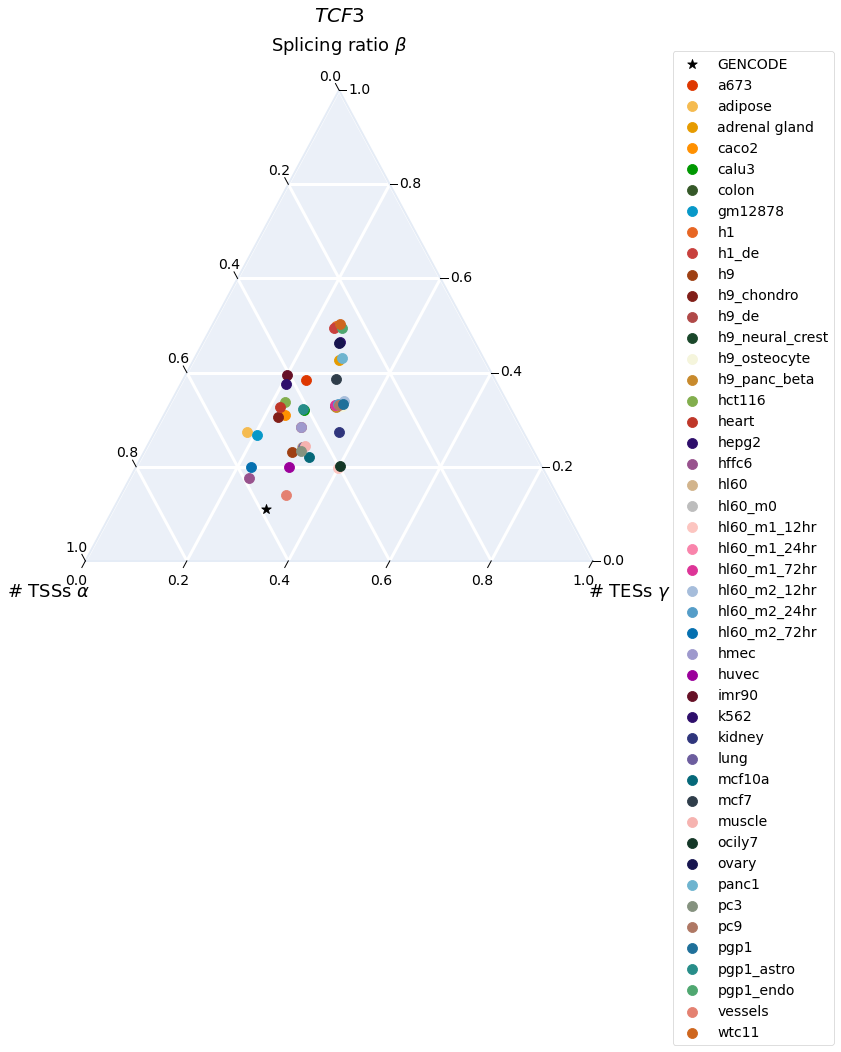

In [32]:
# gene example
_ = plot_dorito(counts,
            top='splicing_ratio', 
            gene='TCF3',
            hue='source',
            cmap=c_dict,
            jitter=True,
            mmap={'GENCODE': '*'},
            subset={'source':list(set(counts.source.unique().tolist())-set(['all', 'obs']))})

In [29]:
# counts.loc[counts.gname == 'TCF3']

## Sectors

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
counts = pd.read_csv('triplets.tsv', sep='\t')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


source    sector  n_genes  total_genes  % annotated / observed genes
1  GENCODE  splicing      195        58780                      0.331745
2  GENCODE       tes     3599        58780                      6.122831
3  GENCODE       tss     3096        58780                      5.267098
1      obs  splicing      890        25198                      3.532026
2      obs       tes     1617        25198                      6.417176
3      obs       tss     1761        25198                      6.988650

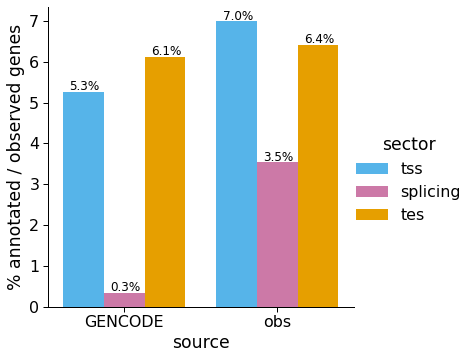

In [3]:
plot_sector_gene_counts(counts)